# Fundus Disease Detection - V2


Mount Drive

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [6]:
!mkdir images

In [7]:
!ls

categorized_disorders  categorized_images  images  models


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

Data preparation

In [8]:
import tensorflow as tf 

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.05,
    dtype=None,
    rescale = 1.0/255.0
    # rescale = None
)

In [9]:
dire = '/content/gdrive/MyDrive/Kaggle/categorized_images'

train_generator = datagen.flow_from_directory(
    dire,
    batch_size=32,
    class_mode='categorical',                           
    target_size=(224,224),
    subset='training'
)

test_generator = datagen.flow_from_directory(
    dire,
    batch_size=32,
    class_mode='categorical',                           
    target_size=(224,224),
    subset='validation'
)

Found 1188 images belonging to 3 classes.
Found 61 images belonging to 3 classes.


Model

In [33]:
from keras.applications.resnet_v2 import ResNet152V2

base = ResNet152V2(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (224,224,3)
)

234553344/234545216 [==============================] - 2s 0us/step


In [34]:
for layer in base.layers:
    layer.trainable = False

In [35]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()

model.add(base)

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.3))

model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.1))

model.add(Flatten())

model.add(Dense(3, activation="softmax"))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [37]:
from tensorflow import keras

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [25]:
!nvidia-smi

Mon Mar  8 17:08:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    734MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1382013267021190254
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17464965385280256689
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
# from tensorflow import test
# test.is_gpu_available()

from tensorflow import config

config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
from tensorflow import test
test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [38]:
from tensorflow.keras.callbacks import  EarlyStopping

stop_acc = EarlyStopping(monitor = "categorical_accuracy", min_delta = 0.0001, patience = 10, restore_best_weights = True, mode='auto')
stop_loss = EarlyStopping(monitor = "loss", min_delta = 0.0001, patience = 10, restore_best_weights = True, mode='auto')
stop_val_acc = EarlyStopping(monitor = "val_categorical_accuracy", min_delta = 0.0001, patience = 10, restore_best_weights = True, mode='auto')
stop_val_loss = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 10, restore_best_weights = True, mode='auto')

history = model.fit(
    train_generator,
    batch_size = 32,
    epochs = 50,
    validation_data = test_generator,
    callbacks = [stop_acc, stop_loss, stop_val_acc, stop_val_loss]
)

Epoch 1/50
38/38 [==============================] - 235s 6s/step - loss: 8.0906 - categorical_accuracy: 0.6123 - val_loss: 1.2826 - val_categorical_accuracy: 0.8689
Epoch 2/50
38/38 [==============================] - 65s 2s/step - loss: 3.1468 - categorical_accuracy: 0.7963 - val_loss: 1.0264 - val_categorical_accuracy: 0.8525
Epoch 3/50
38/38 [==============================] - 65s 2s/step - loss: 2.2852 - categorical_accuracy: 0.8330 - val_loss: 0.6073 - val_categorical_accuracy: 0.8197
Epoch 4/50
38/38 [==============================] - 65s 2s/step - loss: 1.9258 - categorical_accuracy: 0.8251 - val_loss: 1.3273 - val_categorical_accuracy: 0.8197
Epoch 5/50
38/38 [==============================] - 65s 2s/step - loss: 0.9540 - categorical_accuracy: 0.8503 - val_loss: 0.5222 - val_categorical_accuracy: 0.8689
Epoch 6/50
38/38 [==============================] - 65s 2s/step - loss: 0.8151 - categorical_accuracy: 0.8339 - val_loss: 0.5733 - val_categorical_accuracy: 0.8197
Epoch 7/50
38/3

In [39]:
base.trainable = True

In [40]:
from tensorflow import keras

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [41]:
history = model.fit(
    train_generator,
    batch_size = 32,
    epochs = 30,
    validation_data = test_generator,
    callbacks = [stop_acc, stop_loss, stop_val_acc, stop_val_loss]
)

Epoch 1/30
38/38 [==============================] - 90s 2s/step - loss: 2.7483 - categorical_accuracy: 0.6804 - val_loss: 1.6968 - val_categorical_accuracy: 0.7541
Epoch 2/30
38/38 [==============================] - 71s 2s/step - loss: 1.4853 - categorical_accuracy: 0.7703 - val_loss: 1.3980 - val_categorical_accuracy: 0.7541
Epoch 3/30
38/38 [==============================] - 74s 2s/step - loss: 0.6367 - categorical_accuracy: 0.8508 - val_loss: 1.1740 - val_categorical_accuracy: 0.7869
Epoch 4/30
38/38 [==============================] - 74s 2s/step - loss: 0.7175 - categorical_accuracy: 0.8255 - val_loss: 1.1696 - val_categorical_accuracy: 0.8033
Epoch 5/30
38/38 [==============================] - 73s 2s/step - loss: 0.3616 - categorical_accuracy: 0.8855 - val_loss: 0.9499 - val_categorical_accuracy: 0.8033
Epoch 6/30
38/38 [==============================] - 73s 2s/step - loss: 0.2627 - categorical_accuracy: 0.9057 - val_loss: 0.6637 - val_categorical_accuracy: 0.8033
Epoch 7/30
38/38

In [42]:
model.save('fundus_tuned_resnet152v2.h5')

In [43]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

Model Training History

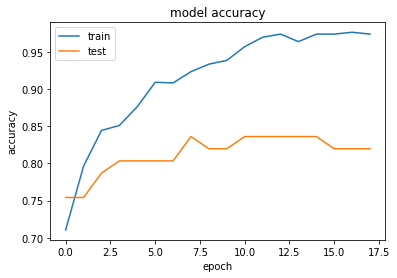

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Loss

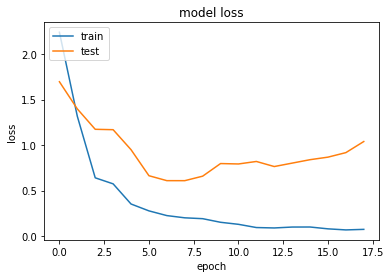

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [46]:
print('Execution finished!')

Execution finished!
